In [1]:
import os

In [23]:
imdb_dir = '../input/imdb-movie-review-sentiment-original-data-set/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

In [4]:
# CREATES ARRAYS OF REVIEWS AND REVIEW LABELS
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type) 

    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname)) 
            texts.append(f.read())
            f.close()

            if label_type == 'neg':
                labels.append(0) 
            else:
                labels.append(1)

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
import numpy as np

# Max of 100 words per reviews
maxlen = 100
# Limits training to 200 samples (meant for practice with small data sets)
training_samples = 200
# Validates models on 10,000 samples
validation_samples = 10000
# Uses top (most frequent) 10,000 words from data set
max_words = 10000

# Tokenizes (vectorizes) text
tokenizer = Tokenizer(num_words=max_words) 
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index)) 

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)

print('Shape of data tensor:', data.shape) 
print('Shape of label tensor:', labels.shape)

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [10]:
# Randomly shuffles data
indices = np.arange(data.shape[0]) 
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Splits data into training and validation sets
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [11]:
# Builds an index that maps words (as strings) to their vector representation (as number vectors)
glove_dir = '../input/glove6b100dtxt'
embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt')) 

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32') 
    embeddings_index[word] = coefs

f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [13]:
# Creates an embedding matrix to feed into embedding layer
# Will have shape (max_words, embedding_dim)
# Each row i represents a word, and the "y-value" contains 
    # the dimensional vector of that respective word in the 
    # reference word index (built during tokenization)
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim)) 

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word) 
        if embedding_vector is not None:
            # Words not found in the embedding index will be all zeros
            embedding_matrix[i] = embedding_vector

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense


model = Sequential()

model.add(Embedding(max_words, embedding_dim, input_length=maxlen)) 
model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Sets weights of embedding layer to weights from embedding_matrix
model.layers[0].set_weights([embedding_matrix])
# Sets embedding layer to untrainable
model.layers[0].trainable = False

model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['acc']) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________


In [18]:
# Trains model
history = model.fit(x_train, 
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

2022-01-11 22:14:33.801724: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
7/7 [==============================] - 2s 127ms/step - loss: 1.7849 - acc: 0.4750 - val_loss: 0.7110 - val_acc: 0.5077
Epoch 2/10
7/7 [==============================] - 1s 91ms/step - loss: 0.5718 - acc: 0.7000 - val_loss: 1.0086 - val_acc: 0.4978
Epoch 3/10
7/7 [==============================] - 1s 110ms/step - loss: 0.4885 - acc: 0.7900 - val_loss: 1.6720 - val_acc: 0.4976
Epoch 4/10
7/7 [==============================] - 1s 108ms/step - loss: 0.4195 - acc: 0.8600 - val_loss: 1.3782 - val_acc: 0.5042
Epoch 5/10
7/7 [==============================] - 1s 91ms/step - loss: 0.4573 - acc: 0.8100 - val_loss: 0.9099 - val_acc: 0.5233
Epoch 6/10
7/7 [==============================] - 1s 111ms/step - loss: 0.1627 - acc: 0.9600 - val_loss: 1.4778 - val_acc: 0.5058
Epoch 7/10
7/7 [==============================] - 1s 108ms/step - loss: 0.2624 - acc: 0.8700 - val_loss: 0.7502 - val_acc: 0.5743
Epoch 8/10
7/7 [==============================] - 1s 110ms/step - loss: 0.0503 - acc: 1.0000

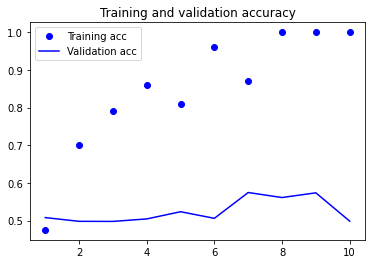

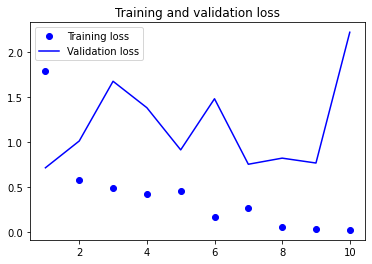

In [21]:
# Graphs results from training
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
# Tests model on testing data over the next couple cells
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type) 
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname)) 
            texts.append(f.read())
            f.close()
            
            if label_type == 'neg':
                labels.append(0) 
            else:
                labels.append(1)

In [28]:
sequences = tokenizer.texts_to_sequences(texts) 
x_test = pad_sequences(sequences, maxlen=maxlen) 
y_test = np.asarray(labels)

In [29]:
model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 2ms/step - loss: 2.2121 - acc: 0.5002


[2.2121148109436035, 0.5002400279045105]